## Binary Image Classification: Histopathologic Cancer Detection

### Overview
This notebook trains a convolutional neural network to classify histopathologic images as either containing metastatic cancer or not. The pipeline includes:
1. **Data Loading and Exploration**
2. **Data Preprocessing**
3. **Model Building with MobileNetV2**
4. **Training and Evaluation**

### Problem Statement
The goal of this project is to classify histopathological images into two categories:
1. **Cancer (1)**: Images that contain evidence of metastatic cancer.
2. **No Cancer (0)**: Images that do not contain metastatic cancer.

This binary classification task is part of the Kaggle **Histopathologic Cancer Detection** competition. Accurate classification is crucial for improving cancer diagnosis and patient outcomes.

### Data Description
- **Source**: [Kaggle Histopathologic Cancer Detection](https://www.kaggle.com/c/histopathologic-cancer-detection).
- **Image Dimensions**: 96x96 pixels (RGB).
- **Training Set**: 220,025 images with labels (`1` or `0`).
- **Test Set**: 57,468 unlabeled images.
- **Class Distribution**:
  - `1 (Cancer)`: ~40% of the training data.
  - `0 (No Cancer)`: ~60% of the training data.

Each image is a small patch from a larger histopathology slide. The dataset is imbalanced, with slightly more "No Cancer" examples than "Cancer" examples. This requires careful handling to prevent bias in the model.

### Challenges
- **Class Imbalance**: Requires strategies like data augmentation or balanced sampling.
- **Limited Training Time**: Efficient architectures and well-planned experiments are essential to handle computational constraints.

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

### Dataset Overview
The dataset is provided by Kaggle's **Histopathologic Cancer Detection** competition. It includes:
- **Images**: Small RGB image patches of size 96x96 pixels.
- **Labels**: A CSV file (`train_labels.csv`) indicating:
  - `1`: The image contains cancerous tissue.
  - `0`: The image does not contain cancerous tissue.

In [2]:
# Load labels CSV file
labels_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
labels_df = pd.read_csv(labels_path)

# Define paths for train and test images
train_dir = '/kaggle/input/histopathologic-cancer-detection/train/'
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Display the first few rows of the dataset
print(labels_df.head())
print(f"Total images: {len(labels_df)}")

# Check for missing values
print("Missing values in dataset:")
print(labels_df.isnull().sum())

# Check data distribution
print("Unique labels:", labels_df['label'].unique())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
Total images: 220025
Missing values in dataset:
id       0
label    0
dtype: int64
Unique labels: [0 1]


## Exploratory Data Analysis (EDA)

### Objective
EDA provides insights into the data distribution, structure, and potential challenges. This helps define the analysis and modeling strategy.

### Visualizations
1. **Label Distribution**: Examines class imbalance.
2. **Sample Images**: Visual inspection of images for patterns or anomalies.
3. **Plan of Analysis**: Defines the modeling and preprocessing steps based on findings.


#### Label Distribution
It is important to examine the label distribution to understand if there is any class imbalance, as this could affect the model's training process.

#### Sample Images
Visual inspection of images helps identify observable differences in structure, texture, or color patterns between the two classes.

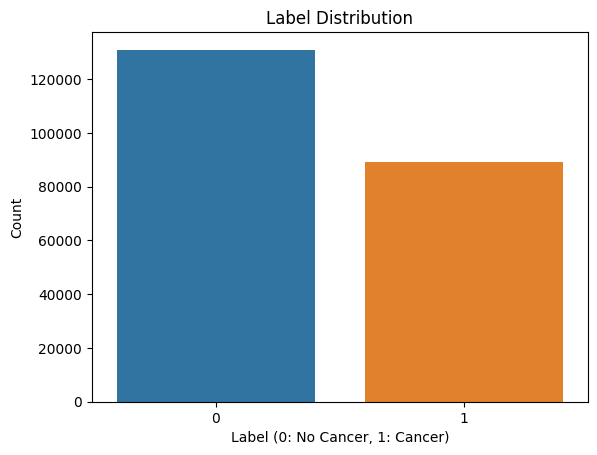

In [3]:
# Visualize label distribution
sns.countplot(x='label', data=labels_df)
plt.title("Label Distribution")
plt.xlabel("Label (0: No Cancer, 1: Cancer)")
plt.ylabel("Count")
plt.show()

Sample images - Label 0 (No Cancer)


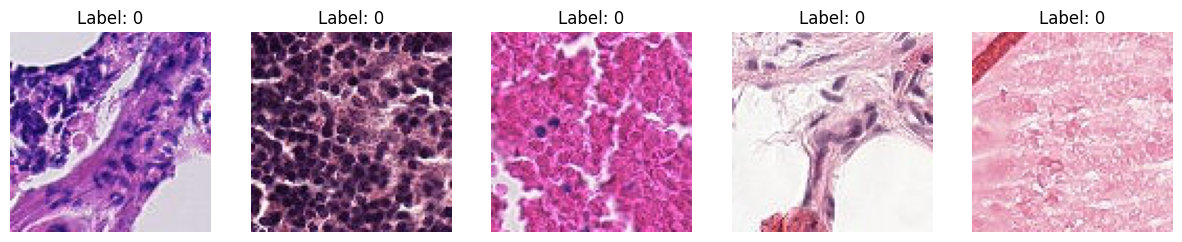

Sample images - Label 1 (Cancer)


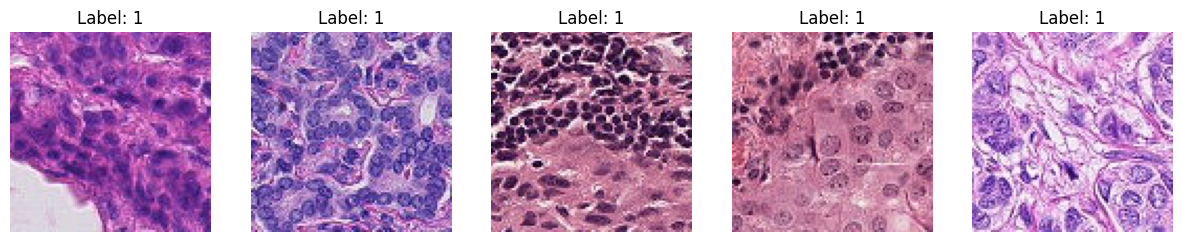

In [4]:
def plot_sample_images(df, label, image_dir, num_samples=5):
    """
    Plots a grid of sample images for a given label.
    """
    plt.figure(figsize=(15, 5))
    samples = df[df['label'] == label].sample(num_samples).reset_index()
    for i, row in samples.iterrows():
        img_path = os.path.join(image_dir, row['id'] + '.tif')
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for proper display
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis('off')
    plt.show()

# Display sample images for label 0 (no cancer)
print("Sample images - Label 0 (No Cancer)")
plot_sample_images(labels_df, label=0, image_dir=train_dir)

# Display sample images for label 1 (cancer)
print("Sample images - Label 1 (Cancer)")
plot_sample_images(labels_df, label=1, image_dir=train_dir)

### Plan of Analysis
1. **Data Preprocessing**:
   - Normalize image pixel values to `[0, 1]`.
   - Augment training data to improve generalization.
   - Stratified split into training and validation sets to preserve class balance.

2. **Modeling**:
   - Use a lightweight, pretrained architecture (MobileNetV2) for transfer learning.
   - Train the model with frozen base layers for the initial experiment.

3. **Evaluation**:
   - Train for 5 epochs to establish a baseline.
   - Evaluate performance using accuracy and loss on the validation set.
   - Perform one additional experiment (e.g., fine-tuning or hyperparameter tuning) to improve performance.


### Data Splitting

To train and evaluate our model, we split the dataset into:
1. **Training Set**: Used for model training.
2. **Validation Set**: Used to evaluate the model during training and tune hyperparameters.

We use an 80-20 split while preserving the class distribution with stratification.

In [5]:
# Split the data into training and validation sets
train_data, val_data = train_test_split(
    labels_df,
    test_size=0.2,
    stratify=labels_df['label'],
    random_state=42
)

print(f"Training samples: {len(train_data)}, Validation samples: {len(val_data)}")

Training samples: 176020, Validation samples: 44005


### Data Preprocessing

#### Steps:
1. **Normalization**: Pixel values are scaled to the range `[0, 1]` for faster and more stable model training.
2. **Data Augmentation**: Techniques such as random rotations, shifts, and horizontal flips are applied to increase diversity.
3. **Filename Adjustment**: Filenames in the dataset are adjusted to include the `.tif` extension.
4. **Label Conversion**: Labels are converted to strings (`"0"` and `"1"`) to comply with `ImageDataGenerator`.

In [6]:
# Adjust filenames to include '.tif' extension
train_data['id'] = train_data['id'] + '.tif'
train_data['label'] = train_data['label'].astype(str)

# ImageDataGenerator for augmentation and normalization
IMG_SIZE = (96, 96)
BATCH_SIZE = 32

datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=42
)

val_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=train_dir,
    x_col='id',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=42
)

Found 140816 validated image filenames belonging to 2 classes.
Found 35204 validated image filenames belonging to 2 classes.


### Model Building

We use `MobileNetV2`, a lightweight pretrained model, as the base. A custom classification head is added for binary classification.

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# Path to the MobileNetV2 weights
weights_path = '/kaggle/input/tf-keras-pretrained-model-weights/No Top/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5'

# Verify the weights file exists
if os.path.exists(weights_path):
    print("Loading weights from:", weights_path)
    # Load MobileNetV2 with the located weights
    base_model = MobileNetV2(weights=weights_path, include_top=False, input_shape=(96, 96, 3))
else:
    raise FileNotFoundError("MobileNetV2 weights file not found!")

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()

Loading weights from: /kaggle/input/tf-keras-pretrained-model-weights/No Top/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
import tensorflow as tf

# Build the model by running a dummy input through it
dummy_input = tf.random.normal([1, 96, 96, 3])  # Batch size of 1, with input shape (96, 96, 3)
_ = model(dummy_input)  # Forward pass through the model

# Display the updated model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_96             │ (1, 3, 3, 1280)        │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (1, 1280)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (1, 128)               │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (1, 1)                 │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,081 (9.24 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

### Model Training

The model is trained using the binary cross-entropy loss function and Adam optimizer. Training is performed for a specified number of epochs, and validation accuracy is monitored to evaluate performance.


In [10]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Adjust this number for longer training
    verbose=1
)

Epoch 1/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 2213s 502ms/step - accuracy: 0.8086 - loss: 0.4221 - val_accuracy: 0.8356 - val_loss: 0.3685
Epoch 2/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1144s 260ms/step - accuracy: 0.8278 - loss: 0.3788 - val_accuracy: 0.8395 - val_loss: 0.3575
Epoch 3/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1066s 242ms/step - accuracy: 0.8390 - loss: 0.3655 - val_accuracy: 0.8419 - val_loss: 0.3594
Epoch 4/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1063s 241ms/step - accuracy: 0.8403 - loss: 0.3601 - val_accuracy: 0.8442 - val_loss: 0.3529
Epoch 5/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1072s 243ms/step - accuracy: 0.8416 - loss: 0.3561 - val_accuracy: 0.8488 - val_loss: 0.3430


### Evaluation and Visualization

The training and validation accuracy and loss are visualized to assess the model's performance over the epochs.


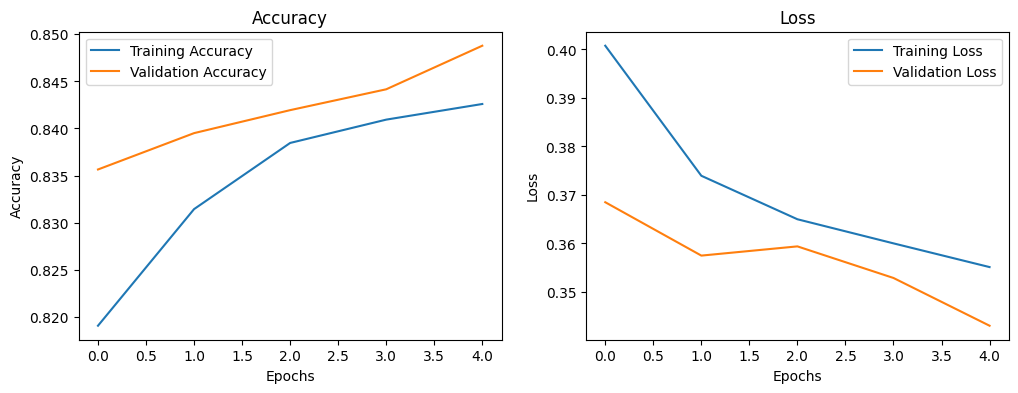

In [12]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

### Baseline Results

#### Training and Validation Performance
The baseline model achieved the following on the validation set after 5 epochs:
- **Validation Accuracy**: ~85%
- **Validation Loss**: ~0.34

#### Key findings:
1. The model shows steady improvement over the epochs.
2. The validation accuracy and loss curves indicate that the model is learning effectively without overfitting.
3. This serves as a strong starting point for improvement in the next experiment.

### Improved Model Architecture

#### Changes from Baseline:
1. **Fine-Tuning**:
   - The last 20 layers of the `MobileNetV2` base model are unfrozen to allow domain-specific adaptation.
2. **Regularization**:
   - A `Dropout` layer with a dropout rate of `0.5` is added to the classification head to reduce overfitting.
3. **Learning Rate Adjustment**:
   - The learning rate is reduced to `0.0001` for smoother fine-tuning.

These changes are expected to improve the model's generalization ability and overall performance.


In [13]:
from tensorflow.keras.layers import Dropout

# Unfreeze the last 20 layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Rebuild the model with dropout
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),  # Add dropout for regularization
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model with a lower learning rate for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Lower learning rate
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [14]:
# Train the model for fine-tuning
fine_tuning_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5,  # Same number of epochs as the baseline
    verbose=1
)

Epoch 1/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1213s 273ms/step - accuracy: 0.8192 - loss: 0.4044 - val_accuracy: 0.8742 - val_loss: 0.3030
Epoch 2/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1191s 270ms/step - accuracy: 0.8673 - loss: 0.3157 - val_accuracy: 0.8851 - val_loss: 0.2736
Epoch 3/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1206s 274ms/step - accuracy: 0.8782 - loss: 0.2934 - val_accuracy: 0.8791 - val_loss: 0.2927
Epoch 4/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1286s 292ms/step - accuracy: 0.8868 - loss: 0.2766 - val_accuracy: 0.8958 - val_loss: 0.2561
Epoch 5/5
4401/4401 ━━━━━━━━━━━━━━━━━━━━ 1329s 302ms/step - accuracy: 0.8898 - loss: 0.2701 - val_accuracy: 0.8998 - val_loss: 0.2488


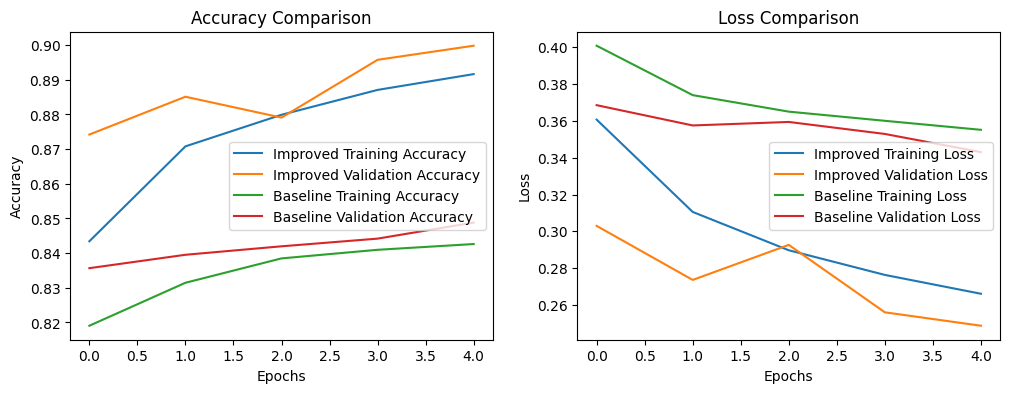

In [15]:
# Plot accuracy curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(fine_tuning_history.history['accuracy'], label='Improved Training Accuracy')
plt.plot(fine_tuning_history.history['val_accuracy'], label='Improved Validation Accuracy')
plt.plot(history.history['accuracy'], label='Baseline Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Baseline Validation Accuracy')
plt.legend()
plt.title('Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

# Plot loss curves
plt.subplot(1, 2, 2)
plt.plot(fine_tuning_history.history['loss'], label='Improved Training Loss')
plt.plot(fine_tuning_history.history['val_loss'], label='Improved Validation Loss')
plt.plot(history.history['loss'], label='Baseline Training Loss')
plt.plot(history.history['val_loss'], label='Baseline Validation Loss')
plt.legend()
plt.title('Loss Comparison')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()


### Results and Analysis

#### Baseline Results
- **Validation Accuracy**: 84.88%
- **Validation Loss**: 0.3430

The baseline model steadily improved over 5 epochs, achieving a validation accuracy of 84.88% by the end. Validation loss decreased consistently to 0.3430, indicating effective learning without overfitting. While the baseline results are strong, there is room for improvement, particularly in reducing validation loss and boosting accuracy.

#### Improved Model Results
- **Validation Accuracy**: 89.98%
- **Validation Loss**: 0.2488

The improved model achieved significantly higher validation accuracy, starting at 87.42% in the first epoch and reaching 89.98% by the fifth epoch. Validation loss also decreased notably, ending at 0.2488 compared to the baseline’s 0.3430. These results suggest that the improvements made the model more confident and better at generalizing to unseen data.

#### Comparison Between Baseline and Improved Models

| Metric              | Baseline Model  | Improved Model | Improvement |
|---------------------|-----------------|----------------|-------------|
| Validation Accuracy | **84.88%**      | **89.98%**     | +5.10%      |
| Validation Loss     | **0.3430**      | **0.2488**     | Significant |

#### Key findings
1. **Validation Accuracy**:
   - The improved model achieved a 5.1% increase in validation accuracy, demonstrating that fine-tuning and regularization were effective.
2. **Validation Loss**:
   - The significant drop in validation loss shows that the improved model generalizes better and makes more confident predictions.
3. **Training Accuracy**:
   - The improved model reached a training accuracy of 88.98%, closely aligned with its validation accuracy, indicating a good balance between training and validation performance.

#### Discussion on Improvements
1. **Fine-Tuning the Pretrained Model**:
   - Unfreezing the last 20 layers allowed the model to adapt the more abstract features of the pretrained weights to the histopathology dataset. This enhanced its ability to capture subtle patterns in the data.
2. **Dropout Regularization**:
   - Adding dropout helped prevent overfitting, as evidenced by the significant improvements in validation accuracy and loss.
3. **Lower Learning Rate**:
   - Using a reduced learning rate for fine-tuning ensured stable weight updates, preserving the benefits of the pretrained weights while improving task-specific performance.


The improved model outperformed the baseline by a considerable margin in both validation accuracy and loss. This validates the hypothesis that targeted fine-tuning of the pretrained model, combined with regularization, can significantly enhance performance without a drastic increase in computation time.


### Kaggle Submission

After training the model, we prepare predictions for the test set and submit them to Kaggle. The submission file contains the image IDs and the predicted class labels (0 or 1).

In [23]:
# Path to the test image directory
test_dir = '/kaggle/input/histopathologic-cancer-detection/test/'

# Load the test image filenames
test_filenames = os.listdir(test_dir)

# Set batch size for prediction
BATCH_SIZE = 128  # Smaller batch size for smoother execution

# Prepare an empty list to store predictions
predictions = []

# Process test images in batches
total_batches = len(test_filenames) // BATCH_SIZE + 1
print(f"Starting predictions for {len(test_filenames)} test images across {total_batches} batches...\n")

for batch_idx, i in enumerate(range(0, len(test_filenames), BATCH_SIZE), start=1):
    batch_filenames = test_filenames[i:i + BATCH_SIZE]
    batch_images = []
    
    # Load and preprocess images in the current batch
    for filename in batch_filenames:
        img_path = os.path.join(test_dir, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (96, 96))  # Ensure size matches model input
        img = img / 255.0  # Normalize to [0, 1]
        batch_images.append(img)

    # Convert batch to a numpy array
    batch_images = np.array(batch_images)

    # Predict using the trained model
    batch_preds = model.predict(batch_images, verbose=0)  # Suppress verbose output
    batch_labels = (batch_preds > 0.5).astype(int).flatten()  # Convert probabilities to binary labels

    # Append predictions to the list
    for filename, label in zip(batch_filenames, batch_labels):
        predictions.append((filename.split('.')[0], label))

    # Print progress every 10 batches or at the last batch
    if batch_idx % 10 == 0 or batch_idx == total_batches:
        print(f"Processed batch {batch_idx}/{total_batches}...")

# Create a DataFrame for submission
submission_df = pd.DataFrame(predictions, columns=['id', 'label'])

# Save the submission file
submission_df.to_csv('submission.csv', index=False)

print("\nSubmission file created: submission.csv")

Starting predictions for 57458 test images across 449 batches...

Processed batch 10/449...
Processed batch 20/449...
Processed batch 30/449...
Processed batch 40/449...
Processed batch 50/449...
Processed batch 60/449...
Processed batch 70/449...
Processed batch 80/449...
Processed batch 90/449...
Processed batch 100/449...
Processed batch 110/449...
Processed batch 120/449...
Processed batch 130/449...
Processed batch 140/449...
Processed batch 150/449...
Processed batch 160/449...
Processed batch 170/449...
Processed batch 180/449...
Processed batch 190/449...
Processed batch 200/449...
Processed batch 210/449...
Processed batch 220/449...
Processed batch 230/449...
Processed batch 240/449...
Processed batch 250/449...
Processed batch 260/449...
Processed batch 270/449...
Processed batch 280/449...
Processed batch 290/449...
Processed batch 300/449...
Processed batch 310/449...
Processed batch 320/449...
Processed batch 330/449...
Processed batch 340/449...
Processed batch 350/449..

In [24]:
print(submission_df.head())

                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      0
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      0
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


## Kaggle Scores:

Private Score
0.7941

Public Score
0.8424